# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Импорт необходимых библиотек для дальнейщего анализа данных: 
import pandas as pd
import numpy as np
import itertools 
import matplotlib.pyplot as plt
import seaborn as sn
from heapq import nlargest

In [2]:
# Импорт библиотек из sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError as err:
    print ('Упс! Нет данных по адресу:', err)
    df_1 = pd.read_csv('geo_data_0.csv')
    df_2 = pd.read_csv('geo_data_1.csv')
    df_3 = pd.read_csv('geo_data_2.csv')

In [4]:
# Данные геологоразведки 1 региона
print(df_1.info())
df_1.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


In [5]:
# Данные геологоразведки 2 региона
print(df_2.info())
df_2.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522


In [6]:
# Данные геологоразведки 3 региона
print(df_3.info())
df_3.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<b>Признаки</b>  
id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).

Проверим разброс данных по трем основным признакам

In [7]:
def boxplot_kit(data):
    fig = plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 4, 1).set(title = 'Первый признак')
    plt.boxplot(data['f0'])

    plt.subplot(1, 4, 2).set(title = 'Второй признак')
    plt.boxplot(data['f1'])

    plt.subplot(1, 4, 3).set(title = 'Третий признак')
    plt.boxplot(data['f2'])
    
    plt.subplot(1, 4, 4).set(title = 'Запас, тыс.баррелей')
    plt.boxplot(data['product'])
    
    return plt.show()

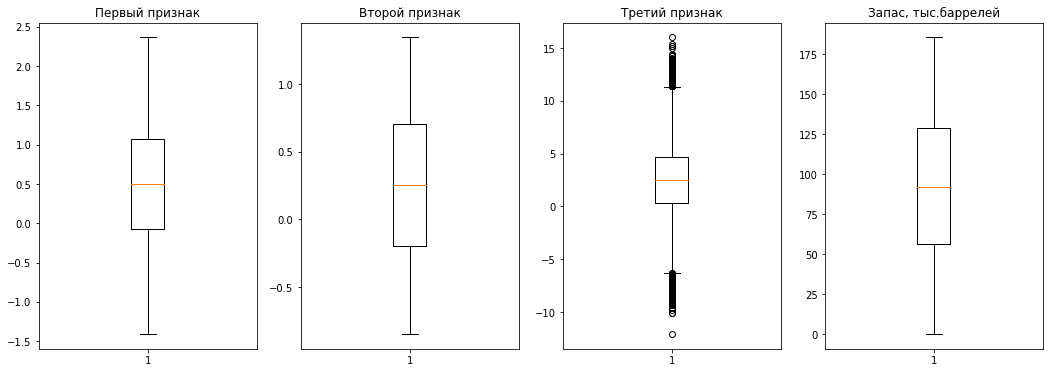

In [8]:
# Первое месторождение
boxplot_kit(df_1)

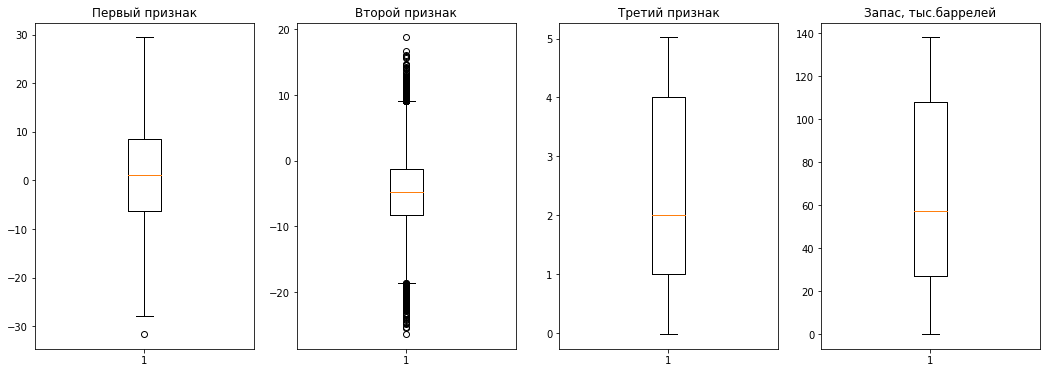

In [9]:
# Второе месторождение
boxplot_kit(df_2)

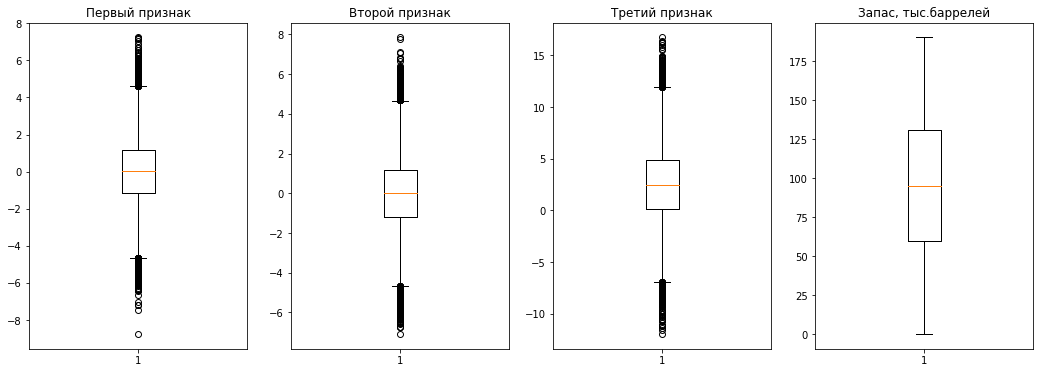

In [10]:
# Третье месторождение
boxplot_kit(df_3)

In [49]:
#Найдем общее количество дубликатов
print('количество дубликатов в данных')
print('регион №1:',df_1.duplicated().sum())
print('регион №2:',df_2.duplicated().sum())
print('регион №3:',df_3.duplicated().sum())

количество дубликатов в данных
регион №1: 0
регион №2: 0
регион №3: 0


In [11]:
num_data = ['f0', 'f1', 'f2', 'product']

In [12]:
corr_matrix = df_1[num_data].corr()
print('Матрица корреляции для данных 1го региона')
corr_matrix

Матрица корреляции для данных 1го региона


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
corr_matrix = df_2[num_data].corr()
print('Матрица корреляции для данных 2го региона')
corr_matrix

Матрица корреляции для данных 2го региона


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [14]:
corr_matrix = df_3[num_data].corr()
print('Матрица корреляции для данных 3го региона')
corr_matrix

Матрица корреляции для данных 3го региона


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


<b>Вывод</b>   
В качестве входных данных имеем 3 датафрейма. Данные в целом хорошо подготовлены, отсутствуют пропуски, значимые выбросы, несоответствия типов данных. Характер распределения значений признаков и целевого признака практически является нормальным.  
  
В данных второго региона замечена аномальная величина корреляции между признаком f2 и целевым признаком product   

## Обучение и проверка модели

Напишем функцию по подготовке данных к обучению модели и функцию по оценке точности ее предсказаний.

In [15]:
# Избавимся от предупреждения о изменение исходных данных в датафрейме.
pd.options.mode.chained_assignment = None

In [16]:
def data_preparetion(data):
# Разделим данные  на целевой признак и остальные признаки используемые для обучения
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    
# Получим валидационный и обучающий наборы данных
    division_random_state = 12345

    features_valid, features_train, target_valid, target_train = train_test_split(
    features, target, test_size=0.25, random_state=division_random_state)
    
# Проверим разделение исходных данных
    print('Размер обучающего набора признаков:',  features_train.shape)
    print('Размер валидационного набора признаков:',  features_valid.shape)
    
# Численные признаки
    numeric = ['f0', 'f1', 'f2']

# Настроим структуру для масштабирования признаков 
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
# Вид признаков до маштабирования    
    print()
    print('Вид обучающего набора признаков до маштабирования:\n', features_train.head(3))
    print('Вид валидационного набора признаков до маштабирования:\n',  features_valid.head(3))
    
# Произведем маштабирование
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
# Вид признаков после маштабирования 
    print()
    print('Вид обучающего набора признаков после маштабирования:\n',  features_train.head(3))
    print('Вид валидационного набора признаков после маштабирования:\n',  features_valid.head(3))
   
    return features_valid, features_train, target_valid, target_train

Функция оценки точности

In [17]:
def model_accuracy(model, data, features_valid, target_valid):
    
    predictions_valid = model.predict(features_valid) #  предсказания модели на валидационной выборке 
    
    RMSE = mean_squared_error(target_valid, predictions_valid)**0.5  #значение метрики RMSE на валидационной выборке
    print('Среднеквадратичная ошибка модели по оценке запасов нефти, тыс. баррелей:', RMSE.round(2))
   
    predict_oil_reserve = predictions_valid.mean()
    print('Cредний запас предсказанного сырья:', predict_oil_reserve)    
        
    oil_reserve = data['product'].mean()
    print()
    print('Средней реальных запас нефти, тыс. баррелей:\n', oil_reserve)
    
    real_product_quantiles = data.quantile([.1, .25, .5, .75], axis = 0)['product']
    print()
    print('Стандартные квантили реальных запасов нефти, тыс. баррелей:\n', real_product_quantiles)

    
    return RMSE, predictions_valid

### Модель оценки запасов нефти 1-го региона

In [18]:
# Подготовим данные
features_valid_1, features_train_1, target_valid_1, target_train_1 = data_preparetion(df_1)

Размер обучающего набора признаков: (25000, 3)
Размер валидационного набора признаков: (75000, 3)

Вид обучающего набора признаков до маштабирования:
              f0        f1        f2
71751  0.948970 -0.057547  2.095727
80493  0.992974  0.206671 -0.142278
2655   1.199854 -0.563356 -1.852991
Вид валидационного набора признаков до маштабирования:
              f0        f1        f2
27212  0.022450  0.951034  2.197333
7866   1.766731  0.007835  6.436602
62041  0.724514  0.666063  1.840177

Вид обучающего набора признаков после маштабирования:
              f0        f1        f2
71751  0.504264 -0.609611 -0.122417
80493  0.554739 -0.086533 -0.812326
2655   0.792043 -1.610973 -1.339686
Вид валидационного набора признаков после маштабирования:
              f0        f1        f2
27212 -0.558510  1.387099 -0.091095
7866   1.442285 -0.480172  1.215742
62041  0.246800  0.822935 -0.201195


Обучение модели на подготовленных данных. В качестве алгоритма выбирается линейная регрессия в соответствии с требованием ТЗ.

In [19]:
model_reg_1 = LinearRegression()  # инициализируем модель LinearRegression
model_reg_1.fit(features_train_1, target_train_1) # обучим модель на тренировочной выборке

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Произведем оценку запасов нефти
RMSE_reg_1, predict_oil_reserve_reg_1 = model_accuracy(model_reg_1, df_1, features_valid_1, target_valid_1)

Среднеквадратичная ошибка модели по оценке запасов нефти, тыс. баррелей: 37.74
Cредний запас предсказанного сырья: 92.1180112790598

Средней реальных запас нефти, тыс. баррелей:
 92.50000000000001

Стандартные квантили реальных запасов нефти, тыс. баррелей:
 0.10     32.585911
0.25     56.497507
0.50     91.849972
0.75    128.564089
Name: product, dtype: float64


### Модель оценки запасов нефти 2-го региона

In [21]:
# Подготовим данные
features_valid_2, features_train_2, target_valid_2, target_train_2 = data_preparetion(df_2)

Размер обучающего набора признаков: (25000, 3)
Размер валидационного набора признаков: (75000, 3)

Вид обучающего набора признаков до маштабирования:
              f0         f1        f2
71751 -0.371866  -1.862494  3.002210
80493  9.015122 -13.881455  1.995363
2655  -6.507568  -4.817448  1.003449
Вид валидационного набора признаков до маштабирования:
               f0        f1        f2
27212  -6.488552 -1.590478  3.001311
7866   18.819463  4.602079  2.996867
62041  10.816499 -3.919653  1.991077

Вид обучающего набора признаков после маштабирования:
              f0        f1        f2
71751 -0.169227  0.578245  0.299601
80493  0.877640 -1.779118 -0.290386
2655  -0.853501 -0.001331 -0.871621
Вид валидационного набора признаков после маштабирования:
              f0        f1        f2
27212 -0.851380  0.631597  0.299074
7866   1.971052  1.846187  0.296470
62041  1.078535  0.174760 -0.292897


In [22]:
model_reg_2 = LinearRegression()  # инициализируем модель LinearRegression
model_reg_2.fit(features_train_2, target_train_2) # обучим модель на тренировочной выборке

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# Произведем оценку запасов нефти
RMSE_reg_2, predict_oil_reserve_reg_2 = model_accuracy(model_reg_2, df_2, features_valid_2, target_valid_2)

Среднеквадратичная ошибка модели по оценке запасов нефти, тыс. баррелей: 0.89
Cредний запас предсказанного сырья: 68.85358463662438

Средней реальных запас нефти, тыс. баррелей:
 68.82500000000002

Стандартные квантили реальных запасов нефти, тыс. баррелей:
 0.10      3.179103
0.25     26.953261
0.50     57.085625
0.75    107.813044
Name: product, dtype: float64


### Модель оценки запасов нефти 3-го региона

In [24]:
# Подготовим данные
features_valid_3, features_train_3, target_valid_3, target_train_3 = data_preparetion(df_3)

Размер обучающего набора признаков: (25000, 3)
Размер валидационного набора признаков: (75000, 3)

Вид обучающего набора признаков до маштабирования:
              f0        f1        f2
71751 -1.444717 -3.861599  2.225805
80493 -1.418617  1.276544 -0.976433
2655  -4.587649 -0.413199  1.649268
Вид валидационного набора признаков до маштабирования:
              f0        f1        f2
27212 -0.906828  1.339033  1.106789
7866  -1.536353 -0.704673 -1.747632
62041 -1.959584  0.356044  3.528659

Вид обучающего набора признаков после маштабирования:
              f0        f1        f2
71751 -0.830988 -2.239384 -0.074691
80493 -0.815920  0.734955 -0.995429
2655  -2.645507 -0.243194 -0.240462
Вид валидационного набора признаков после маштабирования:
              f0        f1        f2
27212 -0.520447  0.771128 -0.396441
7866  -0.883893 -0.411921 -1.217172
62041 -1.128238  0.202101  0.299919


In [25]:
model_reg_3 = LinearRegression()  # инициализируем модель LinearRegression
model_reg_3.fit(features_train_3, target_train_3) # обучим модель на тренировочной выборке

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
# Произведем оценку запасов нефти
RMSE_reg_3, predict_oil_reserve_reg_3 = model_accuracy(model_reg_3, df_3, features_valid_3, target_valid_3)

Среднеквадратичная ошибка модели по оценке запасов нефти, тыс. баррелей: 40.07
Cредний запас предсказанного сырья: 94.95624523467869

Средней реальных запас нефти, тыс. баррелей:
 95.00000000000004

Стандартные квантили реальных запасов нефти, тыс. баррелей:
 0.10     34.592284
0.25     59.450441
0.50     94.925613
0.75    130.595027
Name: product, dtype: float64


<b> Вывод </b>  
Произведено предсказание запасов нефти в трех регионах. Как было показано выше распределение запасов нефти по указанным точкам имеет нормальное распределение, что подтверждается равенством медианных и среднеарифметических значений 1 и 3 региона. Во втором регионе имеется отклонение в распределении. Не смотря на наличие среднеквадратичной ошибки предсказанных запасов нефти, Средний предсказанный запас практически идеально совпадает с реальным. То есть ошибки модели компенсируют друг друга, следовательно при достаточном числе точек модель будет предсказывать запасы нефти с очень высокой точностью, которая соизмерима с точностью прямых/косвенных измерений запасов нефти.  

Исходя из того что в данных существует корреляции между признаком f2 и целевым признаком product равная практически единице, то модель соответствеено "обучилась" делать предсказания тоже с точностью близкой к 100%, о чем свидетельствует среднеквадратичная ошибка стремящияся к очень малой величине.

Предварительно можно сказать, что наиболее перспективным считаем 3 регион имеющим наибольшее значение среднего запаса нефти.


## Подготовка к расчёту прибыли

Рассчитайем достаточный объём сырья для безубыточной разработки новой скважины.   

In [27]:
# Исходнные данные:
N = 500  # Число скважин планируемых к разведке
n = 200  # Число планируемых скважин к разработке
budget = 10**7  # Бюджет на разработку скважин в регионе,тыс. рублей;  
barrel_income = 450 # Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [28]:
# Максимально допустимая стоимость скважины, тыс.рублей
oilwell_price = budget / n 
oilwell_price

50000.0

In [29]:
# Минимальный объем запасов при которых рентабельна разработка скважины, тыс. баррелей
threshold_oilwell_reserve = oilwell_price / barrel_income
threshold_oilwell_reserve

111.11111111111111

Посчитаем запасы нефти у 40% скважин с наибольшими запасами

In [30]:
print('Регион №1', pd.DataFrame(predict_oil_reserve_reg_1).quantile(0.6))
print('Регион №2', pd.DataFrame(predict_oil_reserve_reg_2).quantile(0.6))
print('Регион №3', pd.DataFrame(predict_oil_reserve_reg_3).quantile(0.6))

Регион №1 0    98.191135
Name: 0.6, dtype: float64
Регион №2 0    82.942461
Name: 0.6, dtype: float64
Регион №3 0    99.996286
Name: 0.6, dtype: float64


<b> Вывод </b>  
Пороговое значение запасов нефти, при котором скважина становиться рентабельной превышает на 27% среднее значение запасов в наиболее перспективном 3 регионе. Исходя из дальнейших планов исследовать 500 точек, из которых к разработке выберут 200 наиболее перспективных, то можно сказать, что 60 % точек будут откинуто, однако оставшиеся 40% все еще будут включать скважины с уровнем запасов нефти ниже порогового, при котором достигается рентабельность производства. Отсюда следует рекомендация: либо увеличить число точек к исследованию, либо снизить количество скважин, так как они все равно принесут убыток.

## Расчёт прибыли и рисков 

Сделаем произвольную подвыборку из 500 точек для исследования и с помощью ранее обученной модели выберем 200 наиболее перспективных точек для разработки. Оценим прибыль, которую потенциально можно получить с данного месторождения.

Функция для техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [31]:
# state = np.random.RandomState(123)

# def gross_profit_calculation(features_valid, target_valid, model):
#     gross_profits = []
#     for i in range(1000):
#         # Произведем выборку 500 точек из валидационного набора:
#         features_subsample = features_valid.sample(n=500, replace=True, random_state=state) 
        
#         # Реальный запас нефти на подвыборке
#         real_reserves = target_valid[features_subsample.index]
        
#         # Предсказанный запас нефти на подвыборке
#         subsample_predictions = model.predict(features_subsample)
        
#         #  200 точек с наибольшим реальным запасом нефти
#         best_oil_real_reserve = nlargest(200, real_reserves)
        
#         #  200 точек с наибольшим предсказанным запасом нефти
#         best_oil_predict_reserve = nlargest(200, subsample_predictions)
        
#         # Суммарная прибыль 
#         profit = sum(best_oil_predict_reserve) * barrel_income
        
#         # Валовая прибыль, млн. рублей
#         gross_profit = round((profit - budget)) / 1000
#         gross_profits.append(gross_profit)  
        
#     df_gross_profits = pd.DataFrame(gross_profits, columns=['gross_profits'])
    
#     # Расчитаем 95% доверительный интервал для валовой выручки
#     lower_profit = df_gross_profits['gross_profits'].quantile(0.025)
#     higher_profit = df_gross_profits['gross_profits'].quantile(0.975)
#     print('С вероятностью 95% валовая выручка будет от', lower_profit, 'до', higher_profit, ',млн.рублей')
    
#     maen_profit = df_gross_profits['gross_profits'].mean()
#     print('Средняя выручка:', maen_profit, ',млн.рублей')
    
#     print('Общие статистические данные распределения валовой выручки')
#     print(df_gross_profits['gross_profits'].describe())
    
#     return df_gross_profits, maen_profit, lower_profit, higher_profit

In [32]:
state = np.random.RandomState(123)

def gross_profit_calculation(features_valid, target_valid, model):
    gross_profits = []
    for i in range(1000):
        # Произведем выборку 500 точек из валидационного набора:
        features_subsample = features_valid.sample(n=500, replace=True, random_state=state) 
        
        # Создадим датафрейм реальных запасов нефти на подвыборке
        real_reserves = target_valid[features_subsample.index]
        df = pd.DataFrame(real_reserves)
        
        # Предскажем запас нефти на подвыборке и добавим предсказания в датафрейм
        subsample_predictions = model.predict(features_subsample)
        df.insert(1, 'predictions',subsample_predictions, True)
        
        # Отсортируем в порядке убывания по столбцу с предсказаниями и сбросим индексы
        df = df.sort_values(by='predictions', ascending = False)
        df.reset_index(inplace = True, drop = True)
        
        #  200 точек с наибольшим предсказанным запасом нефти
        best_oil_predict_reserve = df['predictions'].loc[:199]
        
        # Реальные запасы нефти в 200х выбранных точках
        best_oil_real_reserve = df['product'].loc[:199]
        
        # Суммарная прибыль при разработке данных месторождений нефти
        profit = sum(best_oil_real_reserve) * barrel_income
        
        # Валовая прибыль, млн. рублей
        gross_profit = round((profit - budget)) / 1000
        gross_profits.append(gross_profit)  
        
    df_gross_profits = pd.DataFrame(gross_profits, columns=['gross_profits'])
    
    # Расчитаем 95% доверительный интервал для валовой выручки
    lower_profit = df_gross_profits['gross_profits'].quantile(0.025)
    higher_profit = df_gross_profits['gross_profits'].quantile(0.975)
    print('С вероятностью 95% валовая выручка будет от', lower_profit, 'до', higher_profit, ',млн.рублей')
    
    maen_profit = df_gross_profits['gross_profits'].mean()
    print('Средняя выручка:', maen_profit, ',млн.рублей')
    
    print('Общие статистические данные распределения валовой выручки')
    print(df_gross_profits['gross_profits'].describe())
    
    return df_gross_profits, maen_profit, lower_profit, higher_profit

Функция оценки рисков получения убытка

In [33]:
def risk_assessment(profit_df):
    
    negative_profit = profit_df[profit_df['gross_profits'] < 0].shape[0]
    positive_profit = profit_df[profit_df['gross_profits'] >= 0].shape[0]
    
    risk = negative_profit / (negative_profit + positive_profit) * 100
    print('Вероятность убытка состовляет, %:', risk)
    return risk

### Расчет прибыли добычи нефти в 1-ом регионе

In [34]:
df_gross_profits_1, maen_profit_1, lower_profit_1, higher_profit_1 =\
gross_profit_calculation(features_valid_1, target_valid_1, model_reg_1)

С вероятностью 95% валовая выручка будет от -82.968925 до 927.7679999999999 ,млн.рублей
Средняя выручка: 436.447898 ,млн.рублей
Общие статистические данные распределения валовой выручки
count    1000.000000
mean      436.447898
std       261.944443
min      -401.079000
25%       267.835250
50%       442.282500
75%       627.376250
max      1374.635000
Name: gross_profits, dtype: float64


Text(0, 0.5, 'Число эксперементов, шт')

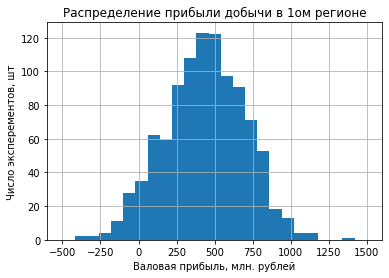

In [44]:
df_gross_profits_1['gross_profits'].hist(bins = 25, range = (-500,1500))
plt.title('Распределение прибыли добычи в 1ом регионе')
plt.xlabel('Валовая прибыль, млн. рублей')
plt.ylabel('Число эксперементов, шт')

In [36]:
risk_1 = risk_assessment(df_gross_profits_1)

Вероятность убытка состовляет, %: 5.5


### Расчет прибыли добычи нефти в 2-ом регионе

In [37]:
df_gross_profits_2, maen_profit_2, lower_profit_2, higher_profit_2 =\
gross_profit_calculation(features_valid_2, target_valid_2, model_reg_2)

С вероятностью 95% валовая выручка будет от 51.00512500000001 до 883.70075 ,млн.рублей
Средняя выручка: 450.506596 ,млн.рублей
Общие статистические данные распределения валовой выручки
count    1000.000000
mean      450.506596
std       211.724954
min      -208.627000
25%       305.766000
50%       450.287000
75%       582.555000
max      1226.821000
Name: gross_profits, dtype: float64


Text(0, 0.5, 'Число эксперементов, шт')

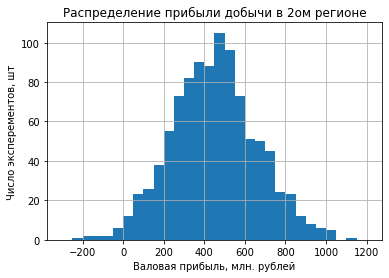

In [48]:
df_gross_profits_2['gross_profits'].hist(bins = 30, range = (-300,1200))
plt.title('Распределение прибыли добычи в 2ом регионе')
plt.xlabel('Валовая прибыль, млн. рублей')
plt.ylabel('Число эксперементов, шт')

In [39]:
risk_2 = risk_assessment(df_gross_profits_2)

Вероятность убытка состовляет, %: 1.3


### Расчет прибыли добычи нефти в 3-ем регионе

In [40]:
df_gross_profits_3, maen_profit_3, lower_profit_3, higher_profit_3 =\
gross_profit_calculation(features_valid_3, target_valid_3, model_reg_3)

С вероятностью 95% валовая выручка будет от -165.42709999999997 до 872.6257999999998 ,млн.рублей
Средняя выручка: 365.47411100000005 ,млн.рублей
Общие статистические данные распределения валовой выручки
count    1000.000000
mean      365.474111
std       267.300223
min      -555.483000
25%       189.371000
50%       372.040000
75%       544.747750
max      1298.188000
Name: gross_profits, dtype: float64


Text(0, 0.5, 'Число эксперементов, шт')

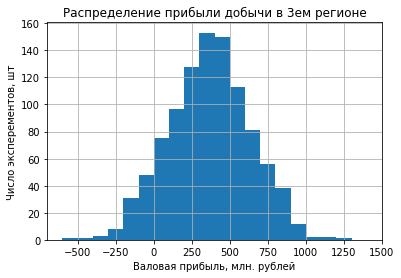

In [47]:
df_gross_profits_3['gross_profits'].hist(bins = 20, range = (-600,1400))
plt.title('Распределение прибыли добычи в 3ем регионе')
plt.xlabel('Валовая прибыль, млн. рублей')
plt.ylabel('Число эксперементов, шт')

In [42]:
risk_3 = risk_assessment(df_gross_profits_3)

Вероятность убытка состовляет, %: 9.2


## Вывод

Для наглядного сравнения всех регионов с месторождениями нефти, составим единую сводную таблицу с основными экономическими характеристиками.

In [43]:
df = pd.DataFrame(
{'Регион':['Месторождение 1', 'Месторождение 2', 'Месторождение 3'], 
'Средняя выручка, млн.руб':[maen_profit_1, maen_profit_2, maen_profit_3],
'С вероятностью 95% выручка составит,от и доб млн.руб':
([lower_profit_1, higher_profit_1],[lower_profit_2, higher_profit_2],[lower_profit_3, higher_profit_3]), 
'Риск убытка, %':[risk_1, risk_2, risk_3] 
})
df

,Регион,"Средняя выручка, млн.руб","С вероятностью 95% выручка составит,от и доб млн.руб","Риск убытка, %"
0,Месторождение 1,436.447898,"[-82.968925, 927.7679999999999]",5.5
1,Месторождение 2,450.506596,"[51.00512500000001, 883.70075]",1.3
2,Месторождение 3,365.474111,"[-165.42709999999997, 872.6257999999998]",9.2


<b> Вывод (старый)</b>  
Месторождение №2 показывает наибольшую среднюю выручку, однако большой разброс 95% доверительного интервала и высокий риск получения убытков, весьма значительных, вплоть до 329.25 млн. руб., не позволяет рекомендовать данное месторождение к разработке. Месторождения №1 и №3 достаточно похожи, но первый номер немного выигрывает по всем метрикам, что и делает его нашим фаворитом в рекомендации на дальнейшее освоение.    
Повысить валовую прибыль так же можно путем увеличения числа точек, рассматриваемых к бурению, так как часть выбранных скважин все же имеют запасы ниже порогового, при котором достигается рентабельность производства. Следовательно, нужно исследовать больше 500 точек, из которых будут выбираться места для бурения, либо вообще не бурить скважины с запасами меньше порогового.


<b> Вывод </b>  
Риски получить убыток при добыче нефти в первом и третьем регионах превышают допустимый порог 2.5 % и соответственно не могут быть рекомендованы к разработке, по крайней мере на текущем уровне исследований. Улучшение работы модели потенциально может сократить эти риски.  
  
Во втором регион, не смотря на изначально значительно худшие показатели запасов нефти, вероятность получить убытки наименьшая и находится в допустимых пределах, установленных в ТЗ. Так же величина среднее выручки наибольшая среди изученных регионов. Таких результатов получилось добиться благодаря очень высокой точности предсказаний модели. 

Таким образом бурение скважин в втором регионе является наиболее выгодным с точки зрения минимальных рисков и наибольшего среднего потенциального дохода.
    